# Lending Club Prediction - Abhijeet Khandelwal

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'
#importing data and displaying it

dataFrame=pd.read_csv('C:\\Users\\bhumi\\Desktop\\repo\\LoanStats3a.csv',encoding = 'UTF-8',skiprows=1)


C:\Users\bhumi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Columns: 145 entries, id to settlement_term
dtypes: float64(115), object(30)
memory usage: 47.1+ MB


In [41]:
#Dropping some columns on the basis of Meta data infromation/Intution
# we are only instrested in the data where person has defaulted or not (not in between cases)
dataFrame.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [5]:
dataFrame.drop(['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d'], axis = 1,inplace=True)

In [6]:
dataFrame.drop(['zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp'],axis=1,inplace=True)

In [7]:
dataFrame.drop(["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"], axis=1,inplace=True)

In [8]:
#filtering only those records where payment has been made or reciver has defaulted the payment
print(dataFrame['loan_status'].value_counts())


Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64


In [9]:
#as we want this data to be of binary classification. we will convert data in fully paid and charged off category.
dataFrame = dataFrame[(dataFrame['loan_status']=='Fully Paid') | (dataFrame['loan_status']=='Charged Off')]

#replacing all the values by 0 or 1
status_replace = {'loan_status':{'Fully Paid':1,"Charged Off":0}}

dataFrame = dataFrame.replace(status_replace)

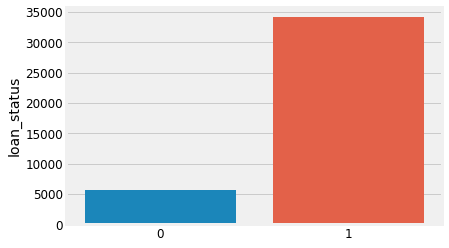

In [10]:
#This dataset is bit unbalanced as majority of the record in dataset is of full amount paid
#we need to keep in find while sampling about this imbalance
g = sns.barplot(y = dataFrame['loan_status'].value_counts(),x=dataFrame['loan_status'].value_counts().index.tolist())
plt.show()

In [11]:
#there will be class imbalance while training machine learning logistic regression model.
# finding out cloumns having just one unique value
#finding out columns having only one unique value as that column will not contribute into modeling and dropping it.
columns_deleted = []
for i in dataFrame.columns:
    col_series = dataFrame[i].dropna().unique()
    if len(col_series) == 1:
        columns_deleted.append(i)
        
dataFrame = dataFrame.drop(columns_deleted,axis=1)
print(columns_deleted)

dataFrame.shape

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'disbursement_method']


(39786, 114)

In [12]:
dataFrame.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'url',
 'desc',
 'purpose',
 'title',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'next_pymnt_d',
 'last_credit_pull_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mth

In [56]:
#lets look the null values in dataset
dataFrame.isnull().sum()

loan_amnt                                         0
term                                              0
int_rate                                          0
installment                                       0
emp_length                                     1078
home_ownership                                    0
annual_inc                                        0
verification_status                               0
loan_status                                       0
url                                           39786
desc                                          12967
purpose                                           0
title                                            11
addr_state                                        0
dti                                               0
delinq_2yrs                                       0
earliest_cr_line                                  0
inq_last_6mths                                    0
mths_since_last_delinq                        25727
mths_since_l

In [13]:
#removing all columns having null value greater then 1% of total records
null_column = []
for i in dataFrame.columns:
    x = dataFrame[i].isnull().sum()
    y = dataFrame[i].notnull().sum()
    if x>= y:
        null_column.append(i)
dataFrame.drop(null_column,axis=1,inplace=True)

In [14]:
dataFrame.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length               1078
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
desc                    12967
purpose                     0
title                      11
addr_state                  0
dti                         0
delinq_2yrs                 0
earliest_cr_line            0
inq_last_6mths              0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                 50
total_acc                   0
last_credit_pull_d          2
pub_rec_bankruptcies      697
debt_settlement_flag        0
dtype: int64

In [15]:
#dropping desc column as it is text
dataFrame.drop(['desc','pub_rec_bankruptcies'],axis=1,inplace=True)

In [16]:
dataFrame.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
emp_length              1078
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
debt_settlement_flag       0
dtype: int64

In [17]:
#now dropping flag column as this is not useful as we have already filtered out data
dataFrame.drop('debt_settlement_flag',axis=1,inplace=True)
dataFrame.dtypes.value_counts()

object     11
float64    10
int64       1
dtype: int64

In [18]:
#identifying data having object/Text datatype
object_columns_df = dataFrame.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])


term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Nov-2017
Name: 0, dtype: object


In [19]:
#Lets check unique values in the object columns
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']

for i in cols:
    print(dataFrame[i].value_counts())

RENT        18918
MORTGAGE    17703
OWN          3064
OTHER          98
NONE            3
Name: home_ownership, dtype: int64
Not Verified       16926
Verified           12844
Source Verified    10016
Name: verification_status, dtype: int64
10+ years    8899
< 1 year     4590
2 years      4394
3 years      4098
4 years      3444
5 years      3286
1 year       3247
6 years      2231
7 years      1775
8 years      1485
9 years      1259
Name: emp_length, dtype: int64
 36 months    29096
 60 months    10690
Name: term, dtype: int64
CA    7105
NY    3817
FL    2872
TX    2734
NJ    1855
IL    1525
PA    1519
VA    1408
GA    1399
MA    1344
OH    1226
MD    1055
AZ     882
WA     842
CO     792
NC     789
CT     754
MI     722
MO     686
MN     616
NV     498
SC     472
WI     460
AL     452
OR     451
LA     436
KY     327
OK     300
KS     272
UT     259
AR     246
DC     214
RI     199
NM     190
WV     177
HI     174
NH     172
DE     114
MT      85
WY      83
AK      81
SD      64
VT  

In [20]:
print(dataFrame['purpose'].value_counts())
print(dataFrame['title'].value_counts())

debt_consolidation    18676
credit_card            5137
other                  4001
home_improvement       2985
major_purchase         2188
small_business         1831
car                    1551
wedding                 948
medical                 695
moving                  583
house                   382
vacation                381
educational             325
renewable_energy        103
Name: purpose, dtype: int64
Debt Consolidation                          2191
Debt Consolidation Loan                     1733
Personal Loan                                661
Consolidation                                517
debt consolidation                           508
Home Improvement                             357
Credit Card Consolidation                    357
Debt consolidation                           334
Small Business Loan                          329
Credit Card Loan                             319
Personal                                     309
Consolidation Loan                       

In [21]:
#removing more columns
dataFrame.drop(["last_credit_pull_d", "earliest_cr_line", "addr_state", "title"], axis=1,inplace=True)

In [22]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}
dataFrame["int_rate"] = dataFrame['int_rate'].str.rstrip('%').astype('float')
dataFrame["revol_util"] = dataFrame["revol_util"].str.rstrip("%").astype("float")
dataFrame = dataFrame.replace(mapping_dict)

In [23]:
dataFrame.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc'],
      dtype='object')

In [24]:
#Plotting heatmap
#Exploring the loan_status x purpose
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(dataFrame[purp_loan[0]], dataFrame[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,0,1
purpose,,
car,160,1391
credit_card,548,4589
debt_consolidation,2792,15884
educational,56,269
home_improvement,351,2634
house,59,323
major_purchase,222,1966
medical,106,589
moving,92,491


In [25]:
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(dataFrame[loan_home[0]], dataFrame[loan_home[1]]).style.background_gradient(cmap = cm)

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,
0,2351,0,18,446,2855
1,15352,3,80,2618,16063


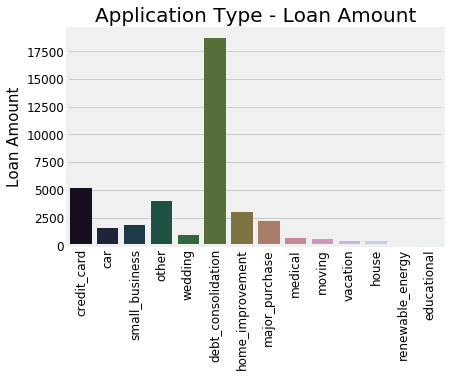

In [26]:
g = sns.countplot(x="purpose",data=dataFrame,
                  palette='cubehelix')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

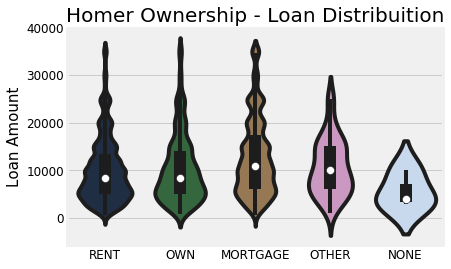

In [27]:
g = sns.violinplot(x="home_ownership",y="loan_amnt",data=dataFrame,
               kind="violin",
               split=True,palette="cubehelix")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

In [28]:
#from above analysis we can deduce that we need to built dummy columns for 4 categorical columns.
dum_cols = ['home_ownership', 'verification_status', 'purpose', 'term']
df_dummy = pd.get_dummies(dataFrame[dum_cols])
dataFrame = pd.concat([dataFrame,df_dummy],axis=1)
dataFrame = dataFrame.drop(dum_cols,axis=1)


In [29]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39786 entries, 0 to 39785
Data columns (total 38 columns):
loan_amnt                              39786 non-null float64
int_rate                               39786 non-null float64
installment                            39786 non-null float64
emp_length                             38708 non-null float64
annual_inc                             39786 non-null float64
loan_status                            39786 non-null int64
dti                                    39786 non-null float64
delinq_2yrs                            39786 non-null float64
inq_last_6mths                         39786 non-null float64
open_acc                               39786 non-null float64
pub_rec                                39786 non-null float64
revol_bal                              39786 non-null float64
revol_util                             39736 non-null float64
total_acc                              39786 non-null float64
home_ownership_MORTGAGE  

[Text(0.5,0,'')]

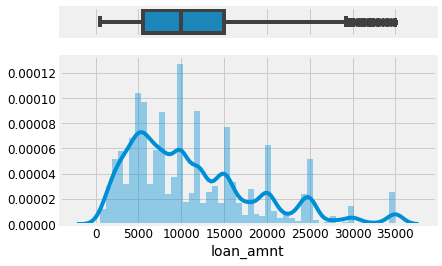

In [30]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(dataFrame["loan_amnt"], ax=ax_box)
sns.distplot(dataFrame["loan_amnt"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


In [31]:
#performing feature scaling
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
#Dropping Y column and then transforming

Y = dataFrame['loan_status']
X = dataFrame.drop('loan_status', axis=1)

#Just for sanity removing null values.
X.dropna(axis=1,inplace=True)

X_new = scale.fit_transform(X)


In [32]:
#Now splitting the data, As discussed earlier this data is imbalanced hence, using SKlearn onesided function for under sampling

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import OneSidedSelection


oss = OneSidedSelection()
X_resampled, y_resampled = oss.fit_sample(X_new, Y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [33]:
#Applying decision tree and random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtc = DecisionTreeClassifier(max_depth=10, max_features=5)
dtc.fit(X_train, y_train)
#print(metrics.confusion_matrix(y_test, dtc.predict(X_test)))
print(metrics.accuracy_score(y_test, dtc.predict(X_test)))

0.83881782090869


In [34]:
#appling random forest
clf = RandomForestClassifier(n_estimators = 20)
clf.fit(X_train, y_train)
print(metrics.accuracy_score(y_test, clf.predict(X_test)))
print(metrics.confusion_matrix(y_test, clf.predict(X_test)))

0.839258932509925
[[  87 1651]
 [ 171 9426]]


In [35]:
#Cross validation Accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, y_test, cv=5)
print(scores)

[0.84215168 0.84126984 0.83458315 0.84024713 0.84554281]
